In [1]:
import tensorflow as tf
from six.moves import cPickle as pickle
from PIL import Image
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
batch_size = 64
patch_size = 5

depth_1 = 32
depth_2 = 64
hidden_1 = 512
hidden_2 = 4096

pixels_height = 32
pixels_width = 32
num_labels = 11
num_channels = 1
predict_size = 30

In [3]:
pickleFile = open('svhn.pickle', 'r')
data = pickle.load(pickleFile)
predict = data['predict']['images'][:predict_size]

In [4]:
pickleFile = open('tensorflow_data.pickle', 'r')
tensorflowData = pickle.load(pickleFile)
predict_X = tensorflowData['predict']['data']
predict_labels = tensorflowData['predict']['label'][:predict_size]
predict_X = predict_X.reshape(-1, pixels_width, pixels_height, 1)[:predict_size]

In [5]:
def toStringLabel(toLabel):
    labels =[]
    for index in range(len(toLabel)):
        sublabel = ""
        for subindex in range(len(toLabel[index])):
            if toLabel[index][subindex] != 10.0:
                sublabel += str(int(toLabel[index][subindex]))
        labels.append(sublabel)
    return labels

predict_Y = toStringLabel(predict_labels)

In [12]:
graph = tf.Graph()
with graph.as_default():
    # Input data
    # Load training, testing and validation data into constants that
    # are attached to the graph
    tf_predict_dataset = tf.placeholder(tf.float32, shape=(predict_size, pixels_width, pixels_height, num_channels))
        
    #Conv1
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth_1], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth_1]))
    
    #Conv2
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, pixels_width, depth_2], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth_2]), dtype=tf.float32)
    
    #Fully connected 1
    layer3_weights = tf.Variable(tf.truncated_normal([hidden_2, hidden_1], stddev=0.1, dtype=tf.float32))
    layer3_biases = tf.Variable(tf.constant(0.1, shape=[512], dtype=tf.float32))
    
    #Outputs
    #First classifer
    cls1_weights = tf.Variable(tf.truncated_normal([hidden_1, num_labels], stddev=0.1, dtype=tf.float32))
    cls1_biases = tf.Variable(tf.constant(0.1, shape=[num_labels], dtype=tf.float32))
    
    #Second classifier
    cls2_weights = tf.Variable(tf.truncated_normal([hidden_1, num_labels], stddev=0.1, dtype=tf.float32))
    cls2_biases = tf.Variable(tf.constant(0.1, shape=[num_labels], dtype=tf.float32))
    
    #Third classifier
    cls3_weights = tf.Variable(tf.truncated_normal([hidden_1, num_labels], stddev=0.1, dtype=tf.float32))
    cls3_biases = tf.Variable(tf.constant(0.1, shape=[num_labels], dtype=tf.float32))
    
    #4th classifier
    cls4_weights = tf.Variable(tf.truncated_normal([hidden_1, num_labels], stddev=0.1, dtype=tf.float32))
    cls4_biases = tf.Variable(tf.constant(0.1, shape=[num_labels], dtype=tf.float32))
    
    #5th classifier
    cls5_weights = tf.Variable(tf.truncated_normal([hidden_1, num_labels], stddev=0.1, dtype=tf.float32))
    cls5_biases = tf.Variable(tf.constant(0.1, shape=[num_labels], dtype=tf.float32))
        
    #model
    def model(data, isTrain = False):
        conv = tf.nn.conv2d(data, layer1_weights, strides = [1, 1, 1, 1], padding='SAME')
        
        relu = tf.nn.relu(conv + layer1_biases)
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding ='SAME')
        
        conv = tf.nn.conv2d(pool, layer2_weights, strides = [1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        shape = pool.get_shape().as_list()
        
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        if isTrain == True:
            hidden = tf.nn.dropout(hidden, 0.7)
        
        logit_cls1 = tf.matmul(hidden, cls1_weights) + cls1_biases
        logit_cls2 = tf.matmul(hidden, cls2_weights) + cls2_biases
        logit_cls3 = tf.matmul(hidden, cls3_weights) + cls3_biases
        logit_cls4 = tf.matmul(hidden, cls4_weights) + cls4_biases
        logit_cls5 = tf.matmul(hidden, cls5_weights) + cls5_biases
        return logit_cls1, logit_cls2, logit_cls3, logit_cls4, logit_cls5
    
    logit_cls1, logit_cls2, logit_cls3, logit_cls4, logit_cls5 = model(tf_predict_dataset, isTrain=True)
    
    # Prediction for training
    prediction = tf.pack([tf.nn.softmax(logit_cls1),
                                tf.nn.softmax(logit_cls2),
                                tf.nn.softmax(logit_cls3), 
                                tf.nn.softmax(logit_cls4), 
                                tf.nn.softmax(logit_cls5)])
    
    # Init saver
    saver = tf.train.Saver()

In [13]:
save_path = "SVHN_MODEL.ckpt"

with tf.Session(graph=graph) as session:
    saver.restore(session, "SVHN_MODEL.ckpt")
    predict_prediction = session.run(prediction, feed_dict={tf_predict_dataset: predict_X[:predict_size]})

In [14]:
predicted_labels = toStringLabel(np.argmax(predict_prediction, 2).T)

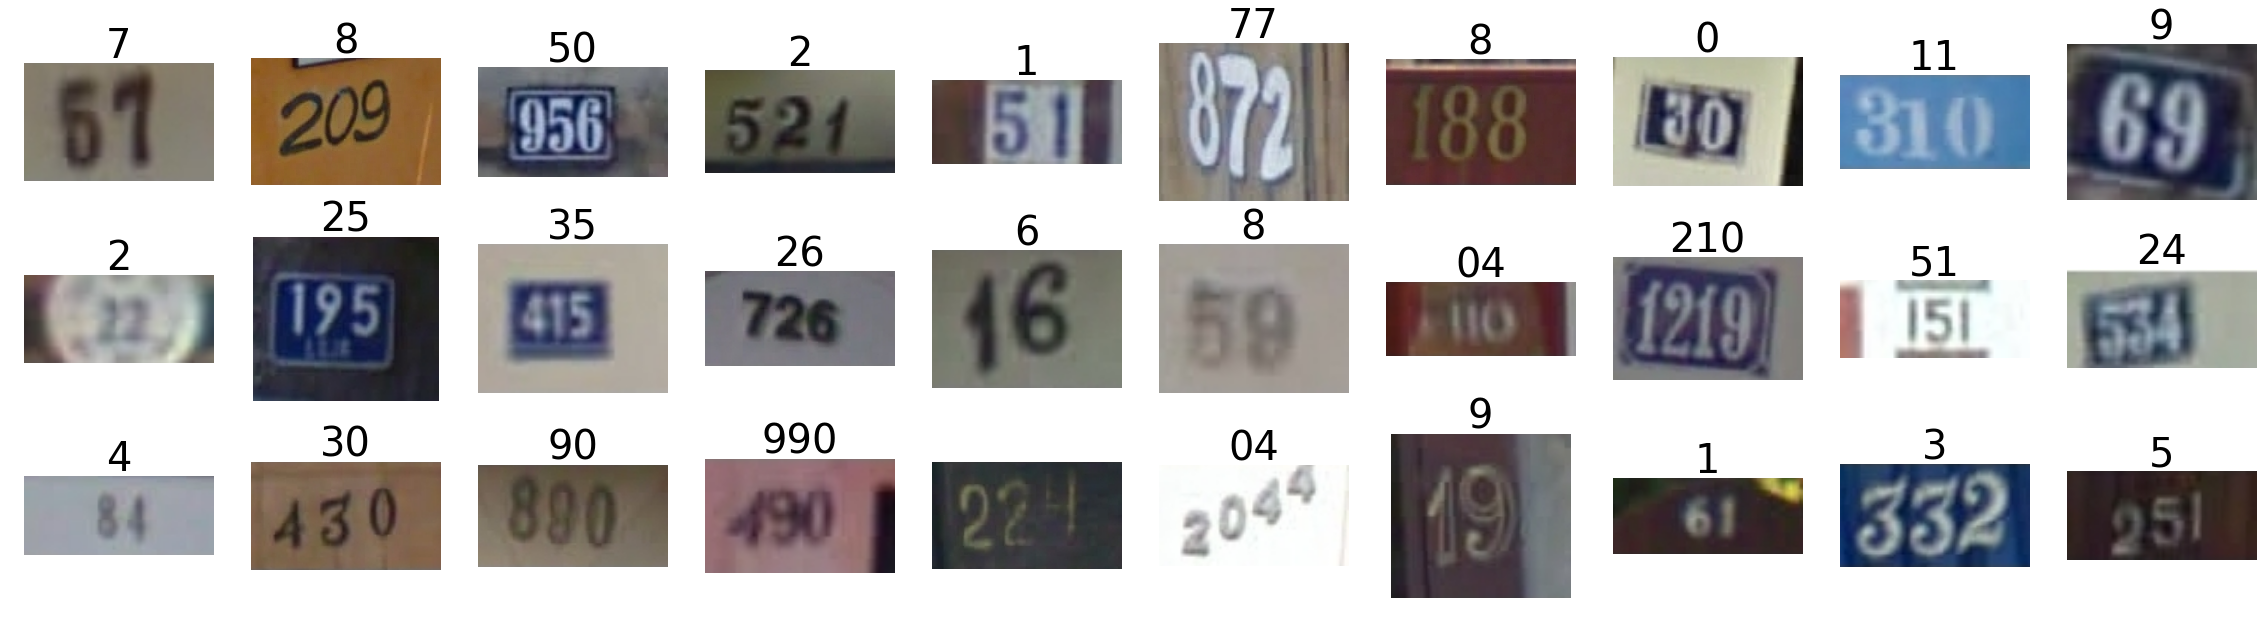

In [16]:
figure, axes = plt.subplots(nrows=3, ncols=10)
figure.set_figheight(10)
figure.set_figwidth(40)
index = 0
for row in range(3):
    for column in range(10):
        img = Image.open('extra/'+predict[index])
        axes[row][column].axis('off')
        axes[row][column].set_title(predicted_labels[index], fontsize=40)
        axes[row][column].imshow(img)
        index = index + 1